In [0]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import shutil
import time

from google.colab import drive
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


## Notebook two: Preprocessing and training
Create a new notebook for this. At the start, download your starter CSV and thumbnails.zip.

The starter code below assumes you have created a zip file called "thumbnails.zip" containing only the resized images from the COOC training set mentioned in the starter CSV, and that you can download it from a URL.

In [0]:
def download_if_missing(url, target, extract=True):
  if os.path.exists(target):
    return target
  return tf.keras.utils.get_file(target, origin=url, extract=extract)

In [0]:
colab_root = "/content/" 

### Download the starter CSV

In [5]:
csv_path = os.path.join(colab_root, "starter.csv")
download_if_missing("https://storage.googleapis.com/applied-dl/mini-vqa/starter.csv",
                     csv_path)

9084928/9078552 [==============================] - 1s 0us/step


'/content/starter.csv'

### Download and unzip your thumbnails

This file is small enough that you can quickly download it with this method.

In [0]:
# Your code here
YOUR_THUMBNAILS_URL = 'https://storage.googleapis.com/applied-deep-learning-sh/thumbnails.zip'

In [7]:
thumbnails_file = os.path.join(colab_root, "thumbnails.zip")
images_folder = os.path.join(colab_root, 'thumbnails/')
download_if_missing(YOUR_THUMBNAILS_URL,
                    thumbnails_file,
                    extract=False)

556507136/556501021 [==============================] - 13s 0us/step


'/content/thumbnails.zip'

In [0]:
!unzip -q $thumbnails_file -d $images_folder

In [9]:
!ls $images_folder

COCO_train2014_000000000025.jpg  COCO_train2014_000000299443.jpg
COCO_train2014_000000000030.jpg  COCO_train2014_000000299474.jpg
COCO_train2014_000000000049.jpg  COCO_train2014_000000299489.jpg
COCO_train2014_000000000064.jpg  COCO_train2014_000000299495.jpg
COCO_train2014_000000000071.jpg  COCO_train2014_000000299498.jpg
COCO_train2014_000000000077.jpg  COCO_train2014_000000299560.jpg
COCO_train2014_000000000078.jpg  COCO_train2014_000000299568.jpg
COCO_train2014_000000000081.jpg  COCO_train2014_000000299618.jpg
COCO_train2014_000000000089.jpg  COCO_train2014_000000299623.jpg
COCO_train2014_000000000109.jpg  COCO_train2014_000000299630.jpg
COCO_train2014_000000000113.jpg  COCO_train2014_000000299641.jpg
COCO_train2014_000000000149.jpg  COCO_train2014_000000299657.jpg
COCO_train2014_000000000151.jpg  COCO_train2014_000000299662.jpg
COCO_train2014_000000000154.jpg  COCO_train2014_000000299672.jpg
COCO_train2014_000000000165.jpg  COCO_train2014_000000299675.jpg
COCO_train2014_0000000002

### Sanity check

At this point, you have all the data you need to train your model (questions, answers, and images) in a convenient and easy to read format. 

Now would be a good time for another santity check. Write a block of code to iterate over the starter CSV file. For each image, make sure you can locate it on disk. E.g., 

``` 
for question, answer, image_name in data:
  img_path = os.path.join(images_folder, image_name)
  assert os.path.exists(img_path)
```

Since we're in a new notebook, again display a few questions, answers, and images - verify everything works as expected.

is the sky blue
yes


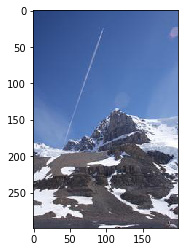

is there snow on the mountains
yes


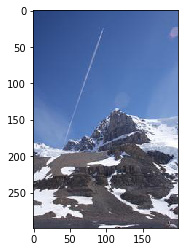

is the window open
yes


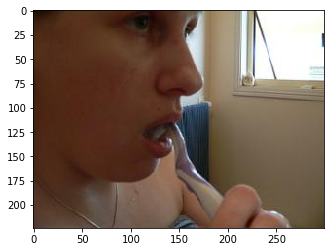

is she brushing
yes


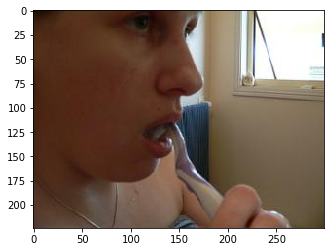

is the man smiling
no


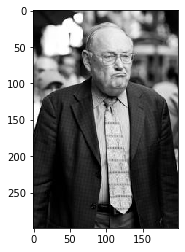

In [10]:
# Your code here
import csv
with open('starter.csv') as myfile:
   reader = csv.reader(myfile, delimiter=',')
   count = 0
   for row in reader:
      question, answer, image = row
      image = image.strip()
      assert os.path.exists(os.path.join('/content/thumbnails/', image))
      if count < 5:
        print(question)
        print(answer)
        img = mpimg.imread('/content/thumbnails/' + image)
        imgplot = plt.imshow(img)
        plt.show()
      count += 1

### Convert answers to numeric format

The answers in the starter CSV are "yes" or "no". For convenience, now would be a good time to change those to 1.0 and 0.0.

In [11]:
# Your code here
# Convert the answers column in the starter CSV to 1.0 and 0.0
# You do not need to update the CSV itself. If you have a data structure
# in memory, you can work with that instead.
import pandas as pd
table = pd.read_csv("starter.csv", names=['question','answer','image'])
for row in table.iterrows():
    if row[1]['answer'] == 'yes':
        row[1]['answer'] = 1.0
    elif row[1]['answer'] == 'no':
        row[1]['answer'] = 0.0
table

,question,answer,image
0,is the sky blue,1,COCO_train2014_000000393221.jpg
1,is there snow on the mountains,1,COCO_train2014_000000393221.jpg
2,is the window open,1,COCO_train2014_000000393223.jpg
3,is she brushing,1,COCO_train2014_000000393223.jpg
4,is the man smiling,0,COCO_train2014_000000393224.jpg
...,...,...,...
140632,is this in focus,0,COCO_train2014_000000393207.jpg
140633,can he be sharpening blades,1,COCO_train2014_000000262136.jpg
140634,is this a normal thing to see in recent history,0,COCO_train2014_000000262136.jpg
140635,is there a computer mouse on the desk,0,COCO_train2014_000000524286.jpg


### Convert image names to absolute paths

Next, for convenience, it may be helpful to update the images column in the starter CSV from filenames ```COCO_train2014_000000320111.jpg``` to absolute paths ```/content/images/COCO_train2014_000000320111.jpg```. This will save you some code down the road when it comes time to open them up (you won't need to worry about the relationship between where the starter CSV file is stored, and your images folder).

In [12]:
# Your code here
# Convert the image filenames in the starter CSV to absolute paths
# You do not need to update the CSV itself. If you have a data structure
# in memory, you can work with that instead.
for row in table.iterrows():
    row[1]['image'] = '/content/thumbnails/' + row[1]['image']   
table

,question,answer,image
0,is the sky blue,1,/content/thumbnails/COCO_train2014_00000039322...
1,is there snow on the mountains,1,/content/thumbnails/COCO_train2014_00000039322...
2,is the window open,1,/content/thumbnails/COCO_train2014_00000039322...
3,is she brushing,1,/content/thumbnails/COCO_train2014_00000039322...
4,is the man smiling,0,/content/thumbnails/COCO_train2014_00000039322...
...,...,...,...
140632,is this in focus,0,/content/thumbnails/COCO_train2014_00000039320...
140633,can he be sharpening blades,1,/content/thumbnails/COCO_train2014_00000026213...
140634,is this a normal thing to see in recent history,0,/content/thumbnails/COCO_train2014_00000026213...
140635,is there a computer mouse on the desk,0,/content/thumbnails/COCO_train2014_00000052428...


### Shuffle and create a test set
For this assignment, you do not need to download the COCO validation or test sets. Instead, shuffle your starter CSV, and use some of the rows as a test set (say, 4,000 rows). Move them to a separate CSV or data structure, and revisit them later. I realize some of the same images may appear in the train and test set (although with different questions). For this assignment, that's okay. If you prefer, you can write code to ensure the test set has unique images that do not appear in the train set.

In [0]:
# Your code here
# Shuffle the starter CSV
# Remove 4,000 rows (or so) and move them to a separate file or data structure
table_shuffle = table.sample(frac=1).reset_index(drop=True)
test_data = table_shuffle.loc[:3999]
table_shuffle = table_shuffle.loc[4000:]

In [0]:
X_test = test_data[['question','image']]
y_test = test_data['answer']

### Limit the size of the dataset, and balance.

The dataset is fairly large. Let's simplify and start small. Instead of working with +/-100,000 questions - a better number would be about 20,000 questions.

As a suggestion, you may also want to balance the data (so you have an equal number of positive and negative questions), just to make it a bit easier to debug your model and verify it's training as expected.

In [0]:
# Your code here
# Limit the size of the starter CSV to 20,000 rows
# Balance the data (so you have an equal number of "yes" and "no" answers) 
# in your 20,000 rows
df_yes = table_shuffle[table_shuffle['answer']==1]
df_no = table_shuffle[table_shuffle['answer']==0]

In [0]:
train_valid_data =  pd.concat([df_yes.iloc[:10000], df_no.iloc[:10000]])

In [0]:
train_valid_data = train_valid_data.sample(frac=1).reset_index(drop=True)

### Create training and validation sets
You may want to do an 80:20 split on your balanced training set, giving you 16,000 training rows, and 4,000 validation rows.

In [18]:
train_valid_data

,question,answer,image
0,does this vehicle appear to be gaining altitude,0,/content/thumbnails/COCO_train2014_00000014193...
1,is there a banana,1,/content/thumbnails/COCO_train2014_00000049314...
2,does this item have a clock on it,1,/content/thumbnails/COCO_train2014_00000007807...
3,do these people love each other,1,/content/thumbnails/COCO_train2014_00000036307...
4,is this something a person should be doing,1,/content/thumbnails/COCO_train2014_00000011755...
...,...,...,...
19995,is the basket close to the top of the stove,1,/content/thumbnails/COCO_train2014_00000034859...
19996,can this airplane fly,1,/content/thumbnails/COCO_train2014_00000045270...
19997,is there a helmet on the motorbike,0,/content/thumbnails/COCO_train2014_00000012473...
19998,is there any trains on the track,0,/content/thumbnails/COCO_train2014_00000030810...


In [0]:
# Your code here
# The scikit-learn utilities (train_test_split) are your friend
X = train_valid_data[['question','image']]
y = train_valid_data['answer']

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=20)

### Verify your train and validation sets look as expected
You cannot spend too much time exploring the data. When I'm developing code for something like this on my own, I often run methods to verify that these splits have the number of rows I expect, to display a few images from each, and to see stats on the class balance. I also write code to verify the splits contain *only* yes/no answers. You may be tired of coding defensively at this point, but I assure you (especially when working with new and increasingly complicated datasets, this effort **always** pays off).

In [21]:
# Your code here.
X_train

,question,image
16451,is the entire room visible,/content/thumbnails/COCO_train2014_00000051534...
3645,are there people in the water,/content/thumbnails/COCO_train2014_00000034169...
5480,is the girl sitting up wearing a purple hat,/content/thumbnails/COCO_train2014_00000010157...
18869,is the rider wearing a helmet,/content/thumbnails/COCO_train2014_00000023789...
3267,is the baby scared of the animals,/content/thumbnails/COCO_train2014_00000043015...
...,...,...
1607,is that a commercial airplane,/content/thumbnails/COCO_train2014_00000011020...
3915,is the zebra charging,/content/thumbnails/COCO_train2014_00000046495...
14729,are the trees bare,/content/thumbnails/COCO_train2014_00000045485...
4367,is there greenery in the kitchen,/content/thumbnails/COCO_train2014_00000037372...


In [22]:
X_valid

,question,image
9812,are the people dressed for the weather,/content/thumbnails/COCO_train2014_00000057720...
7615,is someone standing at the window,/content/thumbnails/COCO_train2014_00000057194...
14799,is this an olympic sport,/content/thumbnails/COCO_train2014_00000044313...
16457,is there a bridge in this scene,/content/thumbnails/COCO_train2014_00000038121...
6563,is the ceiling fan on,/content/thumbnails/COCO_train2014_00000002801...
...,...,...
16897,is there a hand in the picture,/content/thumbnails/COCO_train2014_00000053786...
18821,is this meal vegan,/content/thumbnails/COCO_train2014_00000002124...
5537,do there appear to be pillars on the building ...,/content/thumbnails/COCO_train2014_00000029327...
15251,is the bed made,/content/thumbnails/COCO_train2014_00000037432...


In [23]:
y_train

16451    0
3645     0
5480     0
18869    0
3267     0
        ..
1607     1
3915     0
14729    0
4367     1
15715    0
Name: answer, Length: 16000, dtype: object

In [24]:
y_valid

9812     0
7615     0
14799    0
16457    1
6563     0
        ..
16897    1
18821    0
5537     1
15251    1
19234    1
Name: answer, Length: 4000, dtype: object

In [25]:
X_test

,question,image
0,is the dog angry,/content/thumbnails/COCO_train2014_00000031846...
1,are his skis crossed,/content/thumbnails/COCO_train2014_00000007484...
2,are both cats asleep,/content/thumbnails/COCO_train2014_00000014124...
3,is the table cleared,/content/thumbnails/COCO_train2014_00000012385...
4,are these race horses,/content/thumbnails/COCO_train2014_00000002300...
...,...,...
3995,is there something on top of the dome of the t...,/content/thumbnails/COCO_train2014_00000041697...
3996,is this a forest,/content/thumbnails/COCO_train2014_00000044230...
3997,are the bears in the wild,/content/thumbnails/COCO_train2014_00000032601...
3998,are there fruits or vegetables are the cart,/content/thumbnails/COCO_train2014_00000018660...


In [26]:
y_test

0       0
1       0
2       0
3       1
4       1
       ..
3995    0
3996    0
3997    1
3998    0
3999    1
Name: answer, Length: 4000, dtype: object

In [27]:
y_train.sum()

7979.0

In [28]:
y_valid.sum()

2021.0

In [29]:
y_test.sum()

1877.0

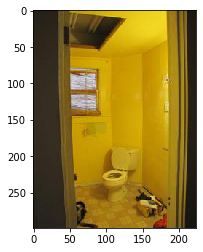

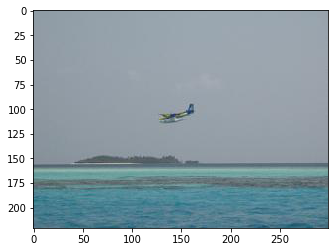

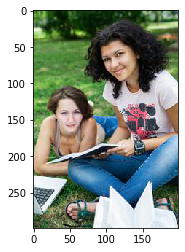

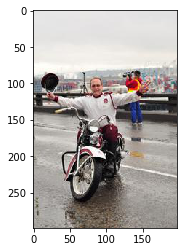

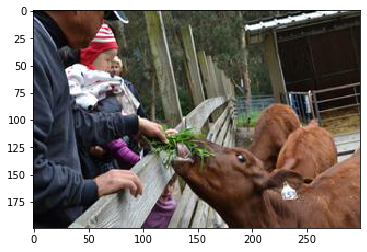

In [30]:
count = 0
for row in X_train.iterrows():
    if count < 5:
        img = mpimg.imread(row[1]['image'])
        imgplot = plt.imshow(img)
        plt.show()
        count += 1

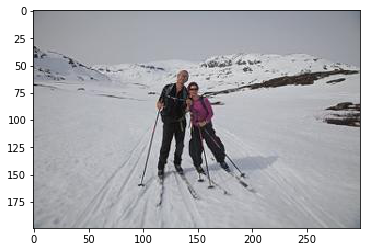

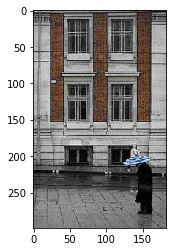

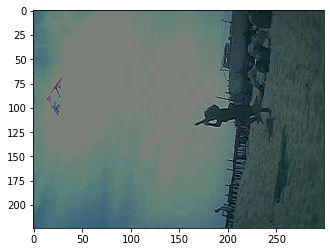

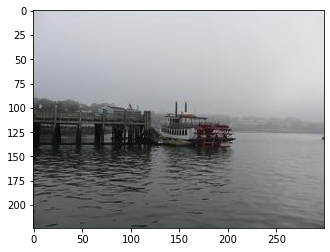

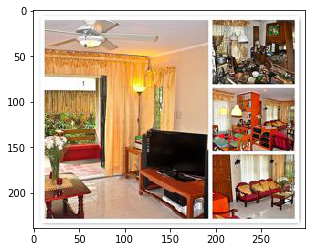

In [31]:
count = 0
for row in X_valid.iterrows():
    if count < 5:
        img = mpimg.imread(row[1]['image'])
        imgplot = plt.imshow(img)
        plt.show()
        count += 1

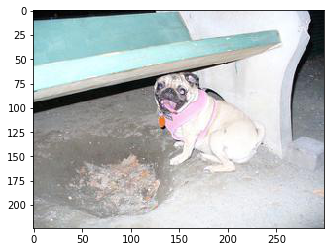

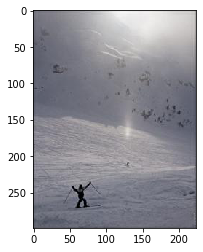

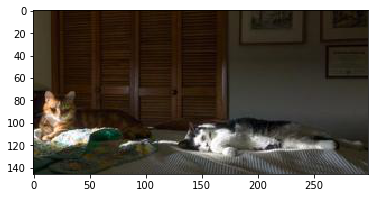

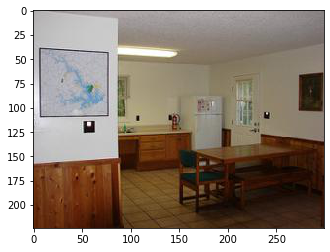

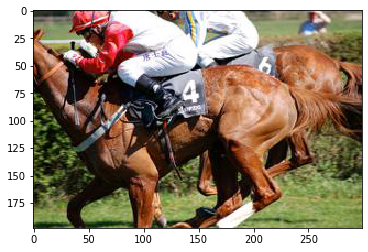

In [32]:
count = 0
for row in X_test.iterrows():
    if count < 5:
        img = mpimg.imread(row[1]['image'])
        imgplot = plt.imshow(img)
        plt.show()
        count += 1


### Forward your images through InceptionV3, and cache activations to disk

Rather than training a CNN from scratch for your VQA model, you'll begin by using activations from a pretrained model.  

* Instead of forward each image repeatedly through the model while training (which will be slow), let's do that once and save the activations to disk. 

* We're saving them to disk (rather than keeping them in memory) to accomodate different sizes of datasets down the road.

I've written a good deal of this code for you, but you should go through it and carefully understand how it works.

In [33]:
# Create a feature extraction model.
# You should not need to modify this (though you may, if you'd like
# to use a model other than Inception).
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 2s 0us/step


In [0]:
# A method to load an image off disk, and extract activations using 
# the model above. You should not need to modify this.
def image_to_activations(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (299, 299))
  activations = tf.keras.applications.inception_v3.preprocess_input(img)
  return activations, image_path

In [35]:
# Your code here

# You'll need to extract activations for every image in your train, validation,
# and test set. First, create a set of the absolute paths to all of these images 
# (image_path_set). Populate this with the absolute paths to all these images.
image_path_set = set()
for row in X_train.iterrows():
    image_path_set.add(row[1]['image'])
for row in X_valid.iterrows():
    image_path_set.add(row[1]['image'])
for row in X_test.iterrows():
    image_path_set.add(row[1]['image'])

print("Images to preprocess", len(image_path_set))
print("This make take a few minutes")

Images to preprocess 18084
This make take a few minutes


In [0]:
# This cell will extract activations for each image and save them to disk 
# in NumPy format. You should not need to modify this.

# Note: we're not saving these activations to the cloud,
# but you certainly could if you wanted to skip this step 
# in the future. If you look into doing that, it's best to save one large
# zip with the activations, and download that and extract it locally
# (rather than doing a bunch of network access to retrieve individual files),
# especially when training your model.

# Create a dataset to load each image off disk, and extract activations
activation_dataset = tf.data.Dataset.from_tensor_slices(list(image_path_set))
activation_dataset = activation_dataset.map(
  image_to_activations, 
  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

# Save all activations to disk in NumPy format
for img_batch, path_batch in activation_dataset:
  batch_features = image_features_extract_model(img_batch)
  for bf, p in zip(batch_features, path_batch):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())  

### Create lists of questions, answers, and images for your train, validation, and test set

At this point, you may be reading your starter CSV directly from disk, or you may have your own data structure in memory. Since many of the methods we'll call from this point forward take lists as input, you may find it helpful to create a data structure with three lists, that correspond to the columns from your starter CSV.

In [0]:
# Your code here. Populate these for your training set.
# questions_train = [] # a list of absolute paths to images in your training set
# answers_train = [] # a list of questions in your training set
# images_train = [] # a list of answers (in numeric format) in your training set

# The order of these lists should match (e.g. the question, answer, and image 
# from row i of your train split of the starter CSV should be 
# questions_train[i], answers_train[i], images_train[i]).
questions_train = []
images_train = []
for row in X_train.iterrows():
    questions_train.append(row[1]['question'])
    images_train.append(row[1]['image'])

answers_train = list(y_train)

In [0]:
# Your code here. Populate these for your validation set.
questions_val = [] 
images_val = []
for row in X_valid.iterrows():
    questions_val.append(row[1]['question'])
    images_val.append(row[1]['image'])

answers_val = list(y_valid)

In [0]:
# Your code here. Populate these for your test set
questions_test = []
images_test = []
for row in X_test.iterrows():
    questions_test.append(row[1]['question'])
    images_test.append(row[1]['image'])

answers_test = list(y_test)

### Create and fit a tokenizer

Your model will use a LSTM to process the questions. First, you'll need to vectorize your text. Tokenize the questions, and limit the vocabulary size to a reasonable size (for example, the top 3,000 words). A larger size will make a higher accuracy possible, but complicate and slow your model. Reminder: fit the tokenizer only on the training questions.

In [0]:
# Your code here
VOCAB_SIZE = 3000

In [41]:
# You should not need to modify this code
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(questions_train)

# Note, the tokenizer's word_index will not respect VOCAB_SIZE.
# but, that parameter will be respected in later methods,
# (for example, when you call text_to_sequences).
# Also note that '0' is a reserved index for padding.
print("Word index", len(tokenizer.word_index))

Word index 4700


### Vectorize the questions
In this section, you will use your tokenizer to vectorize the questions using ```texts_to_sequences```. For an example of texts_to_sequences, see this [notebook](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.1-one-hot-encoding-of-words-or-characters.ipynb).


In [0]:
# Your code here
# Use the texts_to_sequences utility to vectorize your training, 
# validation, and test questions. 

# To follow along with the starter code below, you should use
# these naming conventions

sequences_train = tokenizer.texts_to_sequences(questions_train)
sequences_val = tokenizer.texts_to_sequences(questions_val)
sequences_test = tokenizer.texts_to_sequences(questions_test)

### Pad sequences

In this section, you will pad the vectorized questions using ```pad_sequences```. Your maximum sequence length is a design decision, just like vocab size. Advice, start with something short, so your model trains faster (maybe, between 10 and 20).

For an example of pad_sequences, see this [notebook](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.2-understanding-recurrent-neural-networks.ipynb).

In [43]:
# Your code here
# To choose a reasonable sequence length, examine the length of all the 
# tokenized questions in the training set (in words).
# Justify your choice, e.g. you should note that percentage of the 
# training questions that fall under that length (and will not be trimmed), 
# and the number of questions that will be.
not_trim = 0
trim = 0
for seq in sequences_train:
    if len(seq) <= 15:
        not_trim += 1
    else:
        trim += 1
print(not_trim)
print(trim)
print("Percentage of the training questions that fall under length 20: %f" % (not_trim/len(sequences_train)))
print("The number of questions that will be trimmed: %d" % trim)

15981
19
Percentage of the training questions that fall under length 20: 0.998812
The number of questions that will be trimmed: 19


In [0]:
# Your code here
MAX_SEQ_LEN = 15

In [0]:
# Your code here
# Use the pad_sequences utility to pad your training, 
# validation, and test questions.

# To follow along with the rest of the statter code, you can use these
# naming conventions

padded_train = tf.keras.preprocessing.sequence.pad_sequences(sequences_train, maxlen=MAX_SEQ_LEN)
padded_val = tf.keras.preprocessing.sequence.pad_sequences(sequences_val, maxlen=MAX_SEQ_LEN)
padded_test = tf.keras.preprocessing.sequence.pad_sequences(sequences_test, maxlen=MAX_SEQ_LEN)

### Sanity check
You've just done a **bunch** of preprocessing. Optionally, now would be a good time to write a block of code to verify the tokenized and padded sequences are in the format you expect.

In [46]:
# Your code here (optional).
# Since you have a word_index from the tokenizer, you may 
# also want to write code to convert from a vectorized question
# back to a string.
sequences_train

[[1, 2, 1039, 35, 120],
 [5, 7, 19, 6, 2, 30],
 [1, 2, 97, 94, 87, 14, 3, 677, 127],
 [1, 2, 435, 14, 3, 227],
 [1, 2, 140, 1040, 11, 2, 39],
 [1, 7, 3, 149, 107],
 [1, 2, 606, 77],
 [9, 2, 128, 321, 16, 3, 1954, 1955],
 [1, 4, 3, 2643],
 [5, 2, 39, 6, 30],
 [5, 2, 726, 8, 2, 153, 33, 820, 2, 43, 265],
 [5, 2, 292, 6, 2, 30],
 [1, 4, 73, 6, 3, 299],
 [16, 26, 607, 1041, 1042],
 [1, 2, 22, 886, 2, 50, 115],
 [1, 3, 22, 161, 87, 15, 284],
 [1, 4, 3, 197],
 [1, 7, 3, 128, 321],
 [5, 15, 512, 2644, 219],
 [1, 4, 22, 36, 382],
 [1, 4, 40, 198, 6, 3, 92, 887, 11, 641],
 [1, 7, 3, 82, 410, 2, 186],
 [1, 27, 14, 3, 528],
 [54, 4, 25, 3, 322, 307],
 [1, 4, 6, 529, 166],
 [1, 7, 3, 2645, 6, 4, 65],
 [45, 582, 607, 68, 888],
 [1, 4, 10, 14, 96],
 [1, 2, 76, 1956, 6, 194],
 [1, 2, 220, 95],
 [1, 2, 37, 608, 3, 609],
 [5, 2, 466, 14, 530],
 [1, 2, 50, 61, 13, 436, 943],
 [116, 27, 116, 4, 210],
 [1, 4, 10, 88],
 [1, 7, 18, 489, 8, 2, 133],
 [1, 2, 17, 6, 92, 58, 76],
 [5, 64, 1585, 2, 43, 55],
 [1,

In [47]:
sequences_val

[[5, 2, 19, 270, 31, 2, 237],
 [1, 71, 88, 36, 2, 137],
 [1, 4, 21, 1738, 307],
 [1, 7, 3, 445, 6, 4, 100],
 [1, 2, 1019, 836, 8],
 [9, 2, 50, 438],
 [1, 2, 52, 150, 163, 86, 2, 30],
 [1, 2, 10, 278, 301],
 [1, 7, 291, 6, 2, 23],
 [1, 12, 126],
 [1, 2, 114, 8],
 [1, 2, 44, 1010],
 [1, 2, 385, 184, 3, 587],
 [5, 2, 2593, 654, 6],
 [1, 32, 21, 598, 8, 2, 133],
 [5, 26, 61, 31, 3, 492, 8, 2, 145],
 [1, 59, 14, 279, 1735],
 [1, 4, 3, 1892, 648],
 [9, 4, 989, 519],
 [1, 2, 188, 170, 2891],
 [1, 4, 22, 288],
 [1, 4, 41, 169, 2, 130],
 [1, 4, 420, 252],
 [5, 2, 39, 57, 367],
 [5, 2, 76, 1797, 6, 3, 441, 614],
 [1, 59, 247],
 [1, 2, 218, 245],
 [5, 2, 253, 14, 329],
 [1, 2, 29, 80],
 [5, 7, 553, 1048, 2, 1760, 11, 2, 119],
 [1, 2, 83],
 [1, 7, 66, 8, 2, 260],
 [1, 4, 195, 3, 160],
 [1, 2, 10, 88, 6, 30],
 [1, 4, 1214],
 [1, 2, 40, 2, 2300],
 [1, 12, 3, 146],
 [1, 2, 46, 359, 58],
 [1, 4, 3, 2834, 128],
 [1, 2, 10, 215, 1943, 174],
 [5, 64, 39, 88, 87],
 [1, 4, 17, 48, 566, 2],
 [1, 4, 41, 3, 2

In [48]:
sequences_test

[[1, 2, 42, 918],
 [5, 60, 568, 1358],
 [5, 64, 341, 344],
 [1, 2, 70, 1597],
 [5, 15, 572, 157],
 [5, 15, 2, 43, 1129],
 [20, 19, 763, 107],
 [1, 4, 3, 23, 11, 174, 24, 56, 1161, 3],
 [53, 4, 44, 416, 1636],
 [1, 4, 3, 185, 37],
 [1, 59, 247],
 [5, 7, 19, 8, 2, 1561, 13, 2, 50],
 [1, 2, 22, 858, 13, 738],
 [5, 2, 19, 336, 135],
 [1, 4, 35, 1099],
 [1, 7, 3, 6, 2, 911],
 [9, 4, 10, 16, 60, 8],
 [9, 2, 1052, 16, 21, 255],
 [1, 4, 3, 134, 616],
 [5, 7, 19, 8, 2, 1703],
 [1, 4, 3, 224, 180],
 [1, 4, 801, 44],
 [5, 15, 19, 1203, 174],
 [1, 32, 2524],
 [1, 12, 3],
 [1, 32, 3, 143],
 [1, 2, 135, 8],
 [1, 4, 3, 13, 24],
 [5, 2, 356, 6, 194],
 [5, 7, 11, 32, 251, 3, 11, 2, 1898, 306],
 [1, 2, 93, 222, 1563, 2, 130],
 [1, 4, 3, 122, 11],
 [5, 7, 898, 11, 1334],
 [9, 4, 164, 16, 521],
 [1, 12, 3, 889, 51],
 [45, 4, 44, 68, 287, 465],
 [1, 7, 3, 147, 8, 2, 539, 387, 11, 2, 37],
 [1, 7, 3, 1237, 362, 516, 176],
 [1, 7, 3, 606, 6, 4, 327],
 [1, 4, 3, 165, 1018],
 [1, 4, 3],
 [9, 2, 108, 1916, 55, 6

In [49]:
padded_train

array([[   0,    0,    0, ..., 1039,   35,  120],
       [   0,    0,    0, ...,    6,    2,   30],
       [   0,    0,    0, ...,    3,  677,  127],
       ...,
       [   0,    0,    0, ...,    2,  102,  948],
       [   0,    0,    0, ...,    6,    2,  106],
       [   0,    0,    0, ...,   52,    3, 1175]], dtype=int32)

In [50]:
padded_val

array([[   0,    0,    0, ...,   31,    2,  237],
       [   0,    0,    0, ...,   36,    2,  137],
       [   0,    0,    0, ...,   21, 1738,  307],
       ...,
       [   0,    0,    0, ...,  295,    2,   49],
       [   0,    0,    0, ...,    2,   91,  109],
       [   0,    0,    0, ...,    8,   60,  442]], dtype=int32)

In [51]:
padded_test

array([[   0,    0,    0, ...,    2,   42,  918],
       [   0,    0,    0, ...,   60,  568, 1358],
       [   0,    0,    0, ...,   64,  341,  344],
       ...,
       [   0,    0,    0, ...,    6,    2,  139],
       [   0,    0,    0, ...,    5,    2, 1450],
       [   0,    0,    0, ...,    6,    2,   17]], dtype=int32)

In [52]:
for word, index in tokenizer.word_index.items():
    for i in padded_train[2]:
        if index == i:
            print(word)

is
the
a
wearing
up
sitting
girl
hat
purple


In [53]:
questions_train

['is the entire room visible',
 'are there people in the water',
 'is the girl sitting up wearing a purple hat',
 'is the rider wearing a helmet',
 'is the baby scared of the animals',
 'is there a computer  here',
 'is the bathtub clean',
 'does the clock tower have a lightning rod',
 'is this a wc',
 'are the animals in water',
 'are the tiles on the floor all pointing the same direction',
 'are the cows in the water',
 'is this bathroom in a hotel',
 'have they already had drinks',
 'is the person below the plane real',
 'is a person holding up these bananas',
 'is this a restaurant',
 'is there a clock tower',
 'are these tracks frequently used',
 'is this person at work',
 'is this cat sleeping in a black piece of luggage',
 'is there a sign under the mirror',
 'is he wearing a suit',
 'could this be a team sport',
 'is this in someones home',
 'is there a teepee in this image',
 'has dinner already been served',
 'is this man wearing glasses',
 'is the white automobile in motion'

### Create a tf.dataset for training, validation, and testing

The method to create the dataset is provided for you, though you will need to get it working by passing the ```padded_train```, ```answers_train``` ```and images_train``` lists you created above.




In [0]:
# You should not need to modify this.
BATCH_SIZE = 32
BUFFER_SIZE = 1000

In [0]:
# You should not need to modify this.
# Load cached activations off disk.
def load_np(img_path, question, answer):
  activations = np.load(img_path.decode('utf-8')+'.npy')
  return activations, question, answer, img_path

In [0]:
# You should not need to modify this.

# This method will create a dataset that returns four elements.
# - a batch of activations (loaded from disk)
# - a batch of padded questions
# - a batch of numeric answers
# - a batch of absolute paths to the corresponding images
def create_dataset(images, sequences, answers):
  dataset = tf.data.Dataset.from_tensor_slices((images, 
                                                sequences, 
                                                answers))
  # TODO jbgordon@: rewrite this to be clearer
  # Load the cached activations off disk
  dataset = dataset.map(lambda x, y, z: tf.numpy_function(
      load_np, [x, y, z], [tf.float32, tf.int32, tf.float32, tf.string]),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  
  # Shuffle and batch
  dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [0]:
# Your code here

# Call the above method to create train, val, and test datasets.
# If you want to follow along with the starter code, I suggest these
# variable names:

train_ds = create_dataset(images_train, padded_train, answers_train)
val_ds = create_dataset(images_val, padded_val, answers_val)
test_ds = create_dataset(images_test, padded_test, answers_test)

### Sanity check (optional)
That dataset creation method is complicated. Write a block of code that demonstrates how to use the dataset (e.g., retrieve a batch of activations, questions, answeres, and images paths) and verify they look as expected.

In [58]:
# Your code here (optional)
# Verify your datasets are working properly

# Here is code you can use to quickly retrieve a batch of data

my_iterator = iter(train_ds)
activations_batch, questions_batch, answers_batch, paths_batch = next(my_iterator)

print(activations_batch.shape, 
      questions_batch.shape, 
      answers_batch.shape, 
      paths_batch.shape)

print(activations_batch, 
      questions_batch, 
      answers_batch, 
      paths_batch)

(32, 8, 8, 2048) (32, 15) (32,) (32,)
tf.Tensor(
[[[[1.40597140e-02 4.05555069e-01 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 4.14798021e-01]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.89340653e-02
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.72552907e-01
    0.00000000e+00 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 1.23660956e-02 ... 0.00000000e+00
    2.74135619e-01 2.94438861e-02]
   [0.00000000e+00 0.00000000e+00 2.25408271e-01 ... 0.00000000e+00
    0.00000000e+00 4.27527606e-01]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    1.21825919e-01 5.97658396e-01]]

  [[0.00000000e+00 0.00000000e+00 1.88804403e-01 ... 0.00000000e+00
    0.00000000e+00 4.75539982e-01]
   [0.00000000e+00 0.00000000e+00 1.66317135e-01 ... 0.00000000e+00
    0.00000000e+00 6.63204417e-02]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 7.15033934e-02
    7.79041871e-02 2.15915695e-01]
   ...
   [0.00

### Define your VQA model

You can base your code off the example give toward bottom of this [guide](https://keras.io/getting-started/functional-api-guide/) (but use a smaller model to start). Aim for a couple hundred thousand parameters or so

In [0]:
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, LSTM
from tensorflow.keras.models import Model, Sequential

In [0]:
# Your code here
# Below is starter code for your model for you to complete.
# See https://keras.io/getting-started/functional-api-guide/ for the idea.
# The vision model is written for you. You will need to write the question
# model.

# Input to your vision model (activations from Inception-V3,
# loaded off disk disk by the dataset above).
image_input = Input(shape=(8, 8, 2048)) 
vision_model = Sequential()
# Used to reduce the number of parameters (rather using a dense layer here).
vision_model.add(tf.keras.layers.GlobalAveragePooling2D())
# Output of your vision model
encoded_image = vision_model(image_input) 

# Your code here
# Write your test processing model that takes the vectorized and padded
# question as input.
# As in the guide above, you will want to produce an `encoded_question`
# as output
question_input = Input(shape=(15,), dtype='int32') # your code
embedded_question = Embedding(input_dim=10000, output_dim=64, input_length=15)(question_input) # your code
encoded_question = LSTM(64)(embedded_question) # your code

# Concatenate the encoded image and question
merged = tf.keras.layers.concatenate([encoded_image, encoded_question])

# Optionally, add a small dense layer
dense = Dense(128, activation='relu')(merged)

# Next, add a binary classifier on top
output = Dense(1, activation='sigmoid')(dense)

# Your final model
model = Model(inputs=[image_input, question_input], outputs=output)

In [61]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 8, 8, 2048)] 0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 15, 64)       640000      input_3[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [0]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Plot your model
Create a schematic that shows the graph of your model, using [plot_model](https://keras.io/visualization/). This can be helpful to ensure the vision and question paths look at expected (it's also super cool, and more informative than .summary).

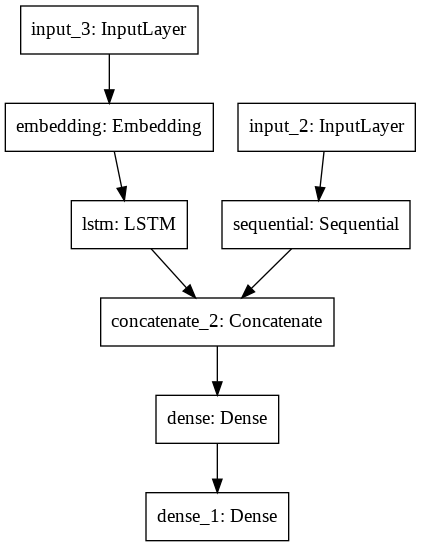

In [63]:
# You should not need to modify this.
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

### Fit your model on a single batch
Before training on your entire dataset, a helpful first step is to train repeatedly on a single batch, and verify the loss goes to zero. If your model is working properly, it should be able to memorize a batch of data. We will use ```model.train_on_batch``` for this.

In [0]:
# You should not nee to modify this.
# Retrieve a batch of data from your train dataset
activations_batch, questions_batch, answers_batch, paths_batch = next(iter(train_ds))

In [65]:
# Your code here

# Train them model repeatedly using model.train_on_batch
# Verify the loss goes to zero after +/- 100 training steps.
# If it does not, now would be a great time to debug 
# before proceeding further.

# e.g.
for epoch in range(100):
    metrics = model.train_on_batch([activations_batch, questions_batch], answers_batch)
    print("Epoch: %d, Loss: %f, Accuracy: %f" % (epoch, metrics[0], metrics[1]))
# metrics is a list (loss is metrics[0], accuracy is metrics[1])

Epoch: 0, Loss: 0.755080, Accuracy: 0.437500
Epoch: 1, Loss: 0.646234, Accuracy: 0.562500
Epoch: 2, Loss: 0.497163, Accuracy: 0.750000
Epoch: 3, Loss: 0.398925, Accuracy: 0.843750
Epoch: 4, Loss: 0.283284, Accuracy: 0.968750
Epoch: 5, Loss: 0.286305, Accuracy: 0.937500
Epoch: 6, Loss: 0.214625, Accuracy: 0.968750
Epoch: 7, Loss: 0.151886, Accuracy: 1.000000
Epoch: 8, Loss: 0.143145, Accuracy: 1.000000
Epoch: 9, Loss: 0.129698, Accuracy: 1.000000
Epoch: 10, Loss: 0.095484, Accuracy: 1.000000
Epoch: 11, Loss: 0.073084, Accuracy: 1.000000
Epoch: 12, Loss: 0.068100, Accuracy: 1.000000
Epoch: 13, Loss: 0.062977, Accuracy: 1.000000
Epoch: 14, Loss: 0.050121, Accuracy: 1.000000
Epoch: 15, Loss: 0.037388, Accuracy: 1.000000
Epoch: 16, Loss: 0.029946, Accuracy: 1.000000
Epoch: 17, Loss: 0.026763, Accuracy: 1.000000
Epoch: 18, Loss: 0.024949, Accuracy: 1.000000
Epoch: 19, Loss: 0.022636, Accuracy: 1.000000
Epoch: 20, Loss: 0.019519, Accuracy: 1.000000
Epoch: 21, Loss: 0.016239, Accuracy: 1.00000

### Use your model to make predictions on the same batch above
Compare the predicted answer to the label. Verify they match.

In [66]:
# You should not need to modify this, but you will want to 
# carefully inspect the output.
for prediction, answer in zip(model.predict(x=[activations_batch, questions_batch]), answers_batch):
  print(prediction, answer.numpy())

[0.99999034] 1.0
[0.9998174] 1.0
[0.00019547] 0.0
[0.99985194] 1.0
[8.317828e-05] 0.0
[0.9998137] 1.0
[0.00071871] 0.0
[9.4383955e-05] 0.0
[0.00023109] 0.0
[5.841255e-06] 0.0
[4.181266e-05] 0.0
[0.99991465] 1.0
[0.9999226] 1.0
[0.00073996] 0.0
[0.99999034] 1.0
[0.9999211] 1.0
[0.9996809] 1.0
[0.99996555] 1.0
[0.99995184] 1.0
[0.99975187] 1.0
[0.00035265] 0.0
[0.00010577] 0.0
[0.00035301] 0.0
[0.00024432] 0.0
[0.9999291] 1.0
[0.0001173] 0.0
[0.9998279] 1.0
[0.00049183] 0.0
[0.9998114] 1.0
[0.999985] 1.0
[0.99980044] 1.0
[0.9999626] 1.0


### Create a checkpoints directory

Once you have been able to train your model on a single batch, it's time to begin training on your training dataset. It may take a while to train for a single epoch, and it would be unfortunate if Colab disconnected after training for a while, and you lost your progress.

* After each training epoch, save the model's weights in a checkpoint file. You can learn more about how to create checkpoints [here](https://www.tensorflow.org/guide/keras/save_and_serialize). 

* To resume training, load the latest checkpoint from disk. This will restore the latest weights and resume your progress. If it does not exist, begin training from scratch.

* As a tip, you may want to store your checkpoints in Google Drive, so you'll still have access to them if Colab disconnects. 

Note that running long jobs is not what Colab is intended for. Normally, you could simple save your checkpoints on the machine you're working on. Saving to drive adds an extra step, but it's worthwhile learning how to do.

Tip: after mounting Drive, **do not** programmatically run any commands to delete files from your checkpoints folder or elsewhere (e.g., by using ```!rm -rf```) in Colab. If you're not careful, you may accidentally wipe out your entire drive if you make a programming mistake. 

* Instead, if you need to delete checkpoints, do so manually through the drive user interface. Note that files deleted through the UI may take a minute or so to "actually" be deleted as reflected by ```!ls``` commands run from Colab.

In [67]:
# Mount drive
drive.mount('/gdrive')
drive_root = '/gdrive/My Drive/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
# If you'd like to save checkpoints in drive, you will need to uncomment
# the code below. Alternatively, you can modify it to save
# checkpoints in Colab (these will not persist if your instance is terminated,
# but you can manually download them if you like).
checkpoint_dir = os.path.join(drive_root, "checkpoints")
checkpoint_dir = os.path.join(checkpoint_dir, "hw4")

# Used for formatting
checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:08d}.ckpt")

In [69]:
# Your code here
# Uncomment this if you'd like to create a checkpoints folder in your drive
print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
  print("Checkpoints folder already exists")
else:
  print("Creating a checkpoints directory")
  os.makedirs(checkpoint_dir)

Checkpoints directory is /gdrive/My Drive/checkpoints/hw4
Checkpoints folder already exists


In [0]:
model.save_weights('/gdrive/My Drive/checkpoints/hw4/path_to_my_tf_checkpoint')

### Restore the latest checkpoint (if it exists).

In [71]:
# You should not need to modify this code.
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest != None:
  print("Loading weights from", latest)
  model.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

Loading weights from /gdrive/My Drive/checkpoints/hw4/path_to_my_tf_checkpoint


### Metrics

In [0]:
# Utilities to help us record metrics.
# You should not need to modify this code
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.BinaryCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')

### Code to evaluate on the validation dataset
The validation dataset may be large. It would be wasteful to evaluate on the entire validation dataset each training epoch. Instead, you could evaluate every N epochs, or, you can use the below methoid to evaluate for a fixed number of steps (batches). This will give you a noisier evaluation, but a useful indicator of how your model is doing over time.

In [0]:
# You should not need to modify this.
def evaluate(max_steps=None):
  steps = 0
  for activation_batch, question_batch, answer_batch, path_batch in val_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = model.predict(x=[activation_batch, question_batch])
    steps += 1 
    # Record metrics after each batch
    val_loss(answer_batch, predictions)
    val_accuracy(answer_batch, predictions)

### Train the model
As before, we'll write our training loop using ```train_on_batch```. This is intermediate in complexity between using ```.fit``` and writing everything from scratch using a ```GradientTape```. Because we're not using ```.fit```. Since we're not using .fit, there's a bit of extra code we need to write ourselves to track loss and accuracy as we go.

In [74]:
# Your code here
# Complete this cell (there are only a few parts to write)

# Used to track loss and accuracy as we go
# You should not need to modify these
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

epochs = 5 # Your code here

# Training loop
for epoch in range(epochs):

  start = time.time()

  # Train for one epoch
  for activation_batch, question_batch, answer_batch, path_batch in train_ds:
    result = model.train_on_batch(x=[activation_batch, question_batch], y=answer_batch)

    # Record metrics after each batch
    train_loss(result[0])
    train_accuracy(result[1])

  # Evaluate for a few steps
  evaluate(max_steps=100)

  # Print progress
  # You should not need to modify this.
  template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
  print(template.format(epoch,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        val_loss.result(),
                        val_accuracy.result() * 100,
                        time.time() - start))
  
  # Record history
  train_loss_history.append(train_loss.result())
  train_acc_history.append(train_accuracy.result() * 100)
  val_loss_history.append(val_loss.result())
  val_acc_history.append(val_accuracy.result() * 100)

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

  # Your code here
  # Save a checkpoint after each epoch
  print("Saving weights")
  model.save_weights('/gdrive/My Drive/checkpoints/hw4/Mymodel')

Epoch 0, Loss: 0.73, Accuracy: 50.54, Val Loss 0.69, Val Accuracy 51.03, Time: 71.3 secs
Saving weights
Epoch 1, Loss: 0.69, Accuracy: 54.23, Val Loss 0.69, Val Accuracy 52.72, Time: 69.9 secs
Saving weights
Epoch 2, Loss: 0.66, Accuracy: 59.88, Val Loss 0.72, Val Accuracy 51.28, Time: 66.2 secs
Saving weights
Epoch 3, Loss: 0.63, Accuracy: 64.01, Val Loss 0.73, Val Accuracy 51.72, Time: 72.7 secs
Saving weights
Epoch 4, Loss: 0.61, Accuracy: 65.61, Val Loss 0.76, Val Accuracy 52.62, Time: 72.7 secs
Saving weights


### Create plots of your training and validation loss and accuracy

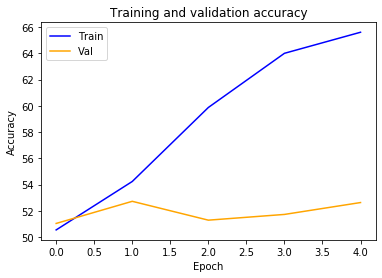

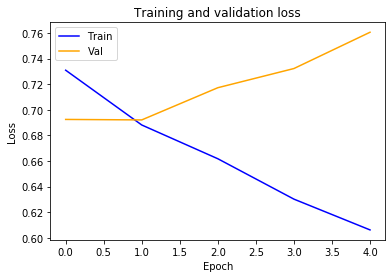

In [75]:
# Your code here
def plot(loss, acc, val_loss, val_acc):

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

plot(train_loss_history, train_acc_history, val_loss_history, val_acc_history)

### At this point, you have end-to-end code to train VQA model
Now you can begin working on increasing accuracy. For this assignment, your model should at least be able to fit your training split reasonably well. You do not need to build a model that performs well on validation to receive full credit (I recently made the starter dataset a bit more difficult, as a result - you may need to train using more data than I want you to do for a homework assignment).

### Run one experiment to improve accuracy

In [0]:
def improved_evaluate(max_steps=None):
  steps = 0
  for activation_batch, question_batch, answer_batch, path_batch in val_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = improved_model.predict(x=[activation_batch, question_batch])
    steps += 1 
    # Record metrics after each batch
    val_loss(answer_batch, predictions)
    val_accuracy(answer_batch, predictions)

In [77]:
# Your code and brief writeup here
# Think about how to improve the accuracy of your model, 
# either on the training or valiation set.
# Design and run an experiment to do so (by writting whatever code is necessary)
# Include the code from your experiment here, and a few notes on the results
# (one paragraph is fine).

# Writeup
# It is hard to improve the vision model because we use a pretrained model. So I decided to change the output 
# dimension of the word embedding layer from 64 to 256, which is closer to the output dimension of the vision
# model and the training loss decreases faster. But when I further increase the output dimension of the word
# embedding layer, the model's training time increase significantly, so I keep the number as 256. And I also
# notice adding dense layers doesn't help improve the accuracy and adding too many layers slow down the training
# process, so I didn't add any dense layer in my improved model.

image_input = Input(shape=(8, 8, 2048)) 
vision_model = Sequential()
# Used to reduce the number of parameters (rather using a dense layer here).
vision_model.add(tf.keras.layers.GlobalAveragePooling2D())
# Output of your vision model
encoded_image = vision_model(image_input) 

# Your code here
# Write your test processing model that takes the vectorized and padded
# question as input.
# As in the guide above, you will want to produce an `encoded_question`
# as output
question_input = Input(shape=(15,), dtype='int32') # your code
embedded_question = Embedding(input_dim=10000, output_dim=256, input_length=15)(question_input) # your code
encoded_question = LSTM(256)(embedded_question) # your code

# Concatenate the encoded image and question
merged = tf.keras.layers.concatenate([encoded_image, encoded_question])

# Optionally, add a small dense layer
# dense = Dense(32, activation='tanh')(merged)
# dense = Dense(128, activation='tanh')(dense)
# dense = Dense(32, activation='tanh')(dense)

# Next, add a binary classifier on top
output = Dense(1, activation='sigmoid')(merged)

# Your final model
improved_model = Model(inputs=[image_input, question_input], outputs=output)

# model summary
improved_model.summary()
# Compile model
improved_model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 8, 8, 2048)] 0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 15, 256)      2560000     input_5[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 2048)         0           input_4[0][0]                    
____________________________________________________________________________________________

In [78]:
# Train the improved model
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

epochs = 5 # Your code here

# Training loop
for epoch in range(epochs):

  start = time.time()

  # Train for one epoch
  for activation_batch, question_batch, answer_batch, path_batch in train_ds:
    result = improved_model.train_on_batch(x=[activation_batch, question_batch], y=answer_batch)

    # Record metrics after each batch
    train_loss(result[0])
    train_accuracy(result[1])

  # Evaluate for a few steps
  improved_evaluate(max_steps=100)

  # Print progress
  # You should not need to modify this.
  template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
  print(template.format(epoch,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        val_loss.result(),
                        val_accuracy.result() * 100,
                        time.time() - start))
  
  # Record history
  train_loss_history.append(train_loss.result())
  train_acc_history.append(train_accuracy.result() * 100)
  val_loss_history.append(val_loss.result())
  val_acc_history.append(val_accuracy.result() * 100)

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

  # Your code here
  # Save a checkpoint after each epoch
  print("Saving weights")
  improved_model.save_weights('/gdrive/My Drive/checkpoints/hw4/MyNewmodel')

Epoch 0, Loss: 0.72, Accuracy: 50.54, Val Loss 0.70, Val Accuracy 51.59, Time: 83.6 secs
Saving weights
Epoch 1, Loss: 0.67, Accuracy: 58.88, Val Loss 0.73, Val Accuracy 53.28, Time: 84.1 secs
Saving weights
Epoch 2, Loss: 0.62, Accuracy: 65.61, Val Loss 0.79, Val Accuracy 53.03, Time: 82.5 secs
Saving weights
Epoch 3, Loss: 0.57, Accuracy: 69.19, Val Loss 0.82, Val Accuracy 52.50, Time: 83.7 secs
Saving weights
Epoch 4, Loss: 0.53, Accuracy: 71.61, Val Loss 0.87, Val Accuracy 52.19, Time: 83.0 secs
Saving weights


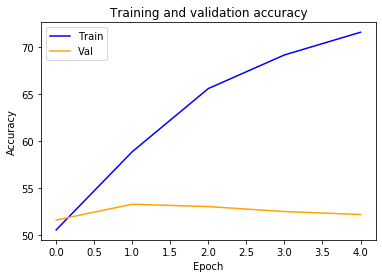

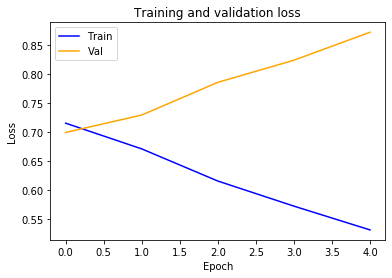

In [79]:
plot(train_loss_history, train_acc_history, val_loss_history, val_acc_history)

### Finally, evaluate your model on the test set
How well did it do? This assignment is lengthy. For our purposes, it's fine to report the accuracy - and you're done :) 

For a proper evaluation, take a look at this [paper](https://arxiv.org/abs/1612.00837), as discussed in class.

Note: if your model is performing poorly on the test set, you can still receive full credit for this assignment as mentioned above. 

In [80]:
# Restore the latest checkpoint
latest = tf.train.latest_checkpoint(checkpoint_dir)
assert latest != None
improved_model.load_weights(latest)
print("loaded weights from", latest)

loaded weights from /gdrive/My Drive/checkpoints/hw4/MyNewmodel


In [81]:
# Your code here
# Calculate accuracy on the test set
test_loss = tf.keras.metrics.BinaryCrossentropy(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

def test():
  for activation_batch, question_batch, answer_batch, path_batch in test_ds:
    predictions = improved_model.predict(x=[activation_batch, question_batch])

    # Record metrics after each batch
    test_loss(answer_batch, predictions)
    test_accuracy(answer_batch, predictions)

test()
print("Test_Loss: {:.2f}, Test_Accuracy: {:.2f}".format(test_loss.result(),test_accuracy.result() * 100))

Test_Loss: 0.90, Test_Accuracy: 52.60


That's it! This was a long assignment, I hope it was a useful (and fun!) learning experience.